# Magnetism

Magntism is only available in Refl1d and it does not support RepeatingMultilayer



## Setup
First configure matplotlib to place figures in notebook and import needed modules

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipp as sc

import easyreflectometry
import refl1d
import refl1d.names

from easyreflectometry.calculators import CalculatorFactory
from easyreflectometry.experiment import Model
from easyreflectometry.experiment import PercentageFhwm
from easyreflectometry.sample import Layer
from easyreflectometry.sample import Material
from easyreflectometry.sample import Multilayer
from easyreflectometry.sample import Sample

For reference we fetch the version of the software packages we are using. 

In [2]:
print(f'numpy: {np.__version__}')
print(f'scipp: {sc.__version__}')
print(f'easyreflectometry: {easyreflectometry.__version__}')
print(f'refl1d: {refl1d.__version__}')

numpy: 1.26.4
scipp: 24.5.0
easyreflectometry: 1.0.2
refl1d: 0.8.16


## Building our model

The system that was used to produce the data shown above is based on a silicon subphase with two layers upon it. 
These two layers are charachterized by having a scattering length density (SLD) of respectively 4 and 8.
Both layers have a rougness of 2 but their thicknesses are 100 and 150 angstrom respectively.
We show the model that will be used graphically below. 

<center>
    <img src='sample/two_layers.png' alt='A slab model description of the two_layers system.' width='300px'></img>
</center>
<center>
    A slab model description of the two layer.
</center>

To construct such a layer structure, first we create each of the materials, the associated layers, and the sub and super phases. 

In [3]:
sld_4 = Material(sld=4.0, isld=0, name='Sld 4')
sld_4_layer = Layer(material=sld_4, thickness=100, roughness=2, name='SLD 4 Layer')

sld_8 = Material(sld=8.0, isld=0, name='Sld 8')
sld_8_layer = Layer(material=sld_8, thickness=150, roughness=2, name='SLD 8 Layer')

vacuum = Material(sld=0, isld=0, name='Vacuum')
superphase = Layer(material=vacuum, thickness=0, roughness=2, name='Vacuum Superphase')

si = Material(sld=2.047, isld=0, name='Si')
subphase = Layer(material=si, thickness=0, roughness=2, name='Si Subphase')

We then create a model for the two layered structures.

In [4]:
two_layers = Multilayer([sld_4_layer, sld_8_layer], name='SLD 4/8 Layer')
sample = Sample(superphase, two_layers, subphase, name='Two Layer Sample')
model = Model(
    sample=sample,
    scale=1,
    background=0,
    name='Two Layer Model',
)

We also need a Refl1d sample

In [5]:
refl1d_sld_4 = refl1d.names.SLD(name="Sld 4", rho=4.0, irho=0)
refl1d_sld_8 = refl1d.names.SLD(name="Sld 8", rho=8.0, irho=0)
refl1d_vacuum = refl1d.names.SLD(name="Vacuum", rho=0, irho=0)
refl1d_si = refl1d.names.SLD(name="Si", rho=2.047, irho=0)

# Refl1d model is inverted as compared to EasyReflectometry, so the order of the layers is reversed
refl1d_sample = (
    refl1d_si(0, 2) | 
    refl1d_sld_8(150, 2) |
    refl1d_sld_4(100, 2) | 
    refl1d_vacuum(0, 2)
) 

## Prepare interface factory

We will use the [Ref1d](https://refl1d.readthedocs.io/en/latest/) and [Refnx](https://refnx.readthedocs.io/) calculator for our analysis. 

In [6]:
interface = CalculatorFactory()

## Comparisons
To validate the implementation we do some comparisons of the reflectevity determined in EasyReflectometry using different calculators or directly in Refl1d.

In [40]:
model_coords = np.linspace(
    start=0.001,
    stop=0.3,
    num=1000,
)

def plot_apply_makeup():
    ax = plt.gca()
    ax.set_xlim([-0.01, 0.35])
    ax.set_ylim([1e-8, 2.5])
    plt.legend()
    plt.yscale('log')
    plt.show()

### Refl1d and EasyReflectometry without magnetism
First we will ensure that the Refl1d calculator is correctly implemented in EasyReflectometry when no magnetic effects are present.

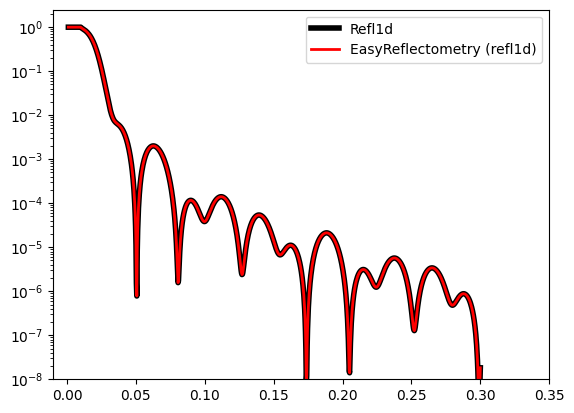

In [8]:
# Refl1d
probe = refl1d.names.QProbe(
        Q=model_coords,
        dQ=np.zeros(len(model_coords)),
        intensity=1,
        background=0,
    )
experiment = refl1d.names.Experiment(probe=probe, sample=refl1d_sample)
model_data_no_magnetism_ref1d_raw = experiment.reflectivity()[1]

plt.plot(model_coords, model_data_no_magnetism_ref1d_raw, '-k', label='Refl1d', linewidth=4)

# EasyReflectometry
interface.switch('refl1d')
model.interface = interface
model.resolution_function = PercentageFhwm(0)
model_interface = model.interface()
model_interface.magnetism = False
model_data_no_magnetism_ref1d_easy = model.interface().fit_func(
    model_coords,
    model.uid,
)
plt.plot(model_coords, model_data_no_magnetism_ref1d_easy, 'r-', label=f'EasyReflectometry ({model_interface.name})', linewidth=2)

plot_apply_makeup()

### EasyReflectometry with and without magnetic layers
We have now reached the point where we can do sa simulation for a sample with magnetic layers.  For this sample we should see a difference in the determined reflectivity.

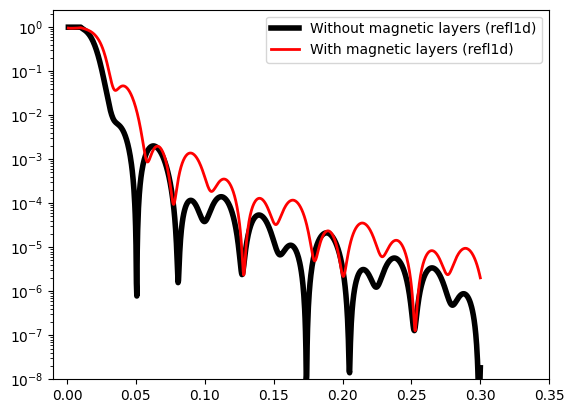

In [9]:
# Without magnetic layers
interface.switch('refl1d')
model.interface = interface
model_interface = model.interface()
model_interface.magnetism = True
model_data_magnetism = model.interface().fit_func(
    model_coords,
    model.uid,
)
plt.plot(model_coords, model_data_magnetism, '-k', label=f'Without magnetic layers ({model_interface.name})', linewidth=4)

# With magnetic layers
interface.switch('refl1d')
model.interface = interface
model_interface = model.interface()
model_interface.magnetism = True
model_interface._wrapper.update_layer(list(model_interface._wrapper.storage['layer'].keys())[1], magnetism_rhoM=10, magnetism_thetaM=70)
model_interface._wrapper.update_layer(list(model_interface._wrapper.storage['layer'].keys())[2], magnetism_rhoM=5, magnetism_thetaM=175)
model_data_magnetism_layer_1 = model.interface().fit_func(
    model_coords,
    model.uid,
)
plt.plot(model_coords, model_data_magnetism_layer_1, 'r-', label=f'With magnetic layers ({model_interface.name})', linewidth=2)

plot_apply_makeup()

As expected do we see a difference in the reflectivity profile for a sample with and without magnetic layers.

### EasyReflectometry and Refl1d with magnetism
The final comparison is to confirm that that we are able to reproduce the raw Refl1d reflectometry in EasyReflectometry when acocunting for magnetism.

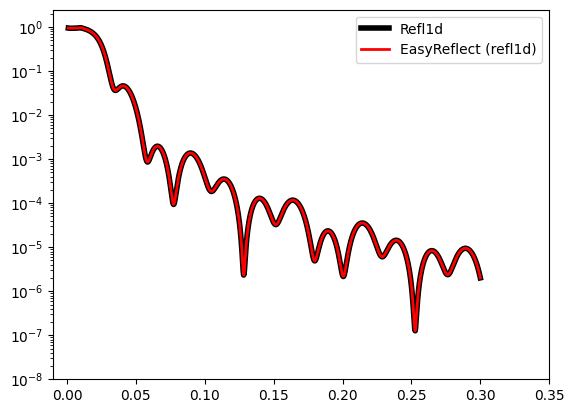

In [10]:

# Refl1d model is inverted as compared to EasyReflectometry, so the order of the layers is reversed
refl1d_sample = (
    refl1d_si(0, 2) | 
    refl1d_sld_8(150, 2, magnetism=refl1d.names.Magnetism(rhoM=5, thetaM=175)) |
    refl1d_sld_4(100, 2, magnetism=refl1d.names.Magnetism(rhoM=10, thetaM=70)) | 
    refl1d_vacuum(0, 2)
) 
probe = refl1d.names.QProbe(
        Q=model_coords,
        dQ=np.zeros(len(model_coords)),
        intensity=1,
        background=0,
    )

four_probes = [probe, None, None]
polarized_probe = refl1d.names.PolarizedQProbe(xs=four_probes, name='polarized')
experiment = refl1d.names.Experiment(probe=polarized_probe, sample=refl1d_sample)
model_data_magnetism_ref1d = experiment.reflectivity()[0][1]
plt.plot(model_coords, model_data_magnetism_ref1d, '-k', label='Refl1d', linewidth=4)

# EasyReflectometry
interface.switch('refl1d')
model.interface = interface
model_interface = model.interface()
model_interface.magnetism = True
model_interface._wrapper.update_layer(list(model_interface._wrapper.storage['layer'].keys())[1], magnetism_rhoM=10, magnetism_thetaM=70)
model_interface._wrapper.update_layer(list(model_interface._wrapper.storage['layer'].keys())[2], magnetism_rhoM=5, magnetism_thetaM=175)
model_data_magnetism_easy = model.interface().fit_func(
    model_coords,
    model.uid,
)
plt.plot(model_coords, model_data_magnetism_easy, 'r-', label=f'EasyReflect ({model_interface.name})', linewidth=2)

plot_apply_makeup()

The two models agree when the magnetic parameters are the same.

In [11]:
print(max(abs(model_data_magnetism_easy - model_data_magnetism_ref1d)))

0.0


# Afterthoughts 
Just for completion we will do a few additional calculations and comparisons of reflectivity.

## Refl1d polarized probe for a single layer sample
 This study is done with magnetism to show the results for polarized probe.

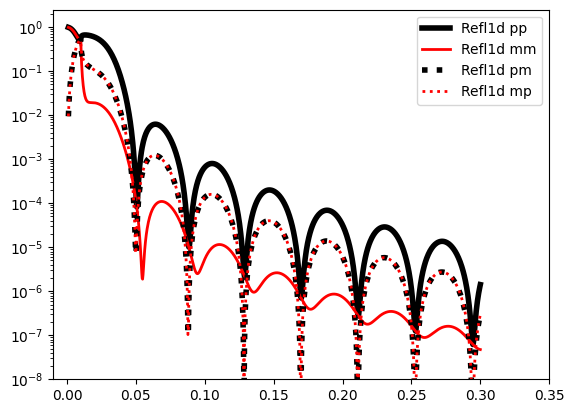

In [41]:
# The magnetism is set to 8. 
# This would double (pp) and cancel out (mm) the magnitude of the reflectivity oscillations when its angle is set to 90
# This would the strongest spin-flipping (pm and mp) when its angle is set to 0  
refl1d_sample = (
    refl1d_si(0, 2) | 
    refl1d_sld_8(150, 2, magnetism=refl1d.names.Magnetism(rhoM=8, thetaM=45)) |
    refl1d_vacuum(0, 2)
) 

probe_pp = refl1d.names.QProbe(
        Q=model_coords,
        dQ=np.zeros(len(model_coords)),
        intensity=1,
        background=0,
    )
probe_pm = refl1d.names.QProbe(
        Q=model_coords,
        dQ=np.zeros(len(model_coords)),
        intensity=1,
        background=0,
    )
probe_mp = refl1d.names.QProbe(
        Q=model_coords,
        dQ=np.zeros(len(model_coords)),
        intensity=1,
        background=0,
    )
probe_mm = refl1d.names.QProbe(
        Q=model_coords,
        dQ=np.zeros(len(model_coords)),
        intensity=1,
        background=0,
    )

four_probes = [probe_pp, probe_pm, probe_mp, probe_mm]
polarized_probe = refl1d.names.PolarizedQProbe(xs=four_probes, name='polarized')
experiment = refl1d.names.Experiment(probe=polarized_probe, sample=refl1d_sample)
model_data_magnetism_ref1d_raw_pp = experiment.reflectivity()[0][1]
model_data_magnetism_ref1d_raw_pm = experiment.reflectivity()[1][1]
model_data_magnetism_ref1d_raw_mp = experiment.reflectivity()[2][1]
model_data_magnetism_ref1d_raw_mm = experiment.reflectivity()[3][1]

plt.plot(model_coords, model_data_magnetism_ref1d_raw_pp, '-k', label='Refl1d pp', linewidth=4)
plt.plot(model_coords, model_data_magnetism_ref1d_raw_mm, '-r', label='Refl1d mm', linewidth=2)
plt.plot(model_coords, model_data_magnetism_ref1d_raw_pm, ':k', label='Refl1d pm', linewidth=4)
plt.plot(model_coords, model_data_magnetism_ref1d_raw_mp, ':r', label='Refl1d mp', linewidth=2)

plot_apply_makeup()

## Refl1 and Refnx in EasyReflectometry.
This study is done without magnetism as Refnx does not support this yet.

In [ ]:
# Refnx
interface.switch('refnx')
model.interface = interface
model_interface = model.interface()
model_data_no_magnetism_refnx = model.interface().fit_func(
    model_coords,
    model.uid,
)
plt.plot(model_coords, model_data_no_magnetism_refnx, 'k-', label=f'EasyReflectometry ({model_interface.name})', linewidth=5)

# Refl1d
interface.switch('refl1d')
model.interface = interface
model_interface = model.interface()
model_data_no_magnetism_ref1d = model.interface().fit_func(
    model_coords,
    model.uid,
)
plt.plot(model_coords, model_data_no_magnetism_ref1d, 'r-', label=f'EasyReflectometry ({model_interface.name})', linewidth=2)

plot_apply_makeup()

## EasyReflectometry with and without magnetism but no magnetic layers
We also want to confirm that we can enable the ability to account for magnetism without causing any significant changes to the reflectivity as determined for a sample without any magnetic layers.

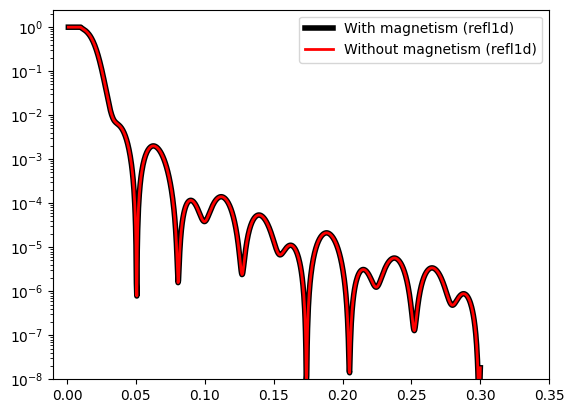

In [16]:
# With Magnitism
interface.switch('refl1d')
model.interface = interface
model_interface = model.interface()
model_interface.magnetism = True
model_data_magnetism = model.interface().fit_func(
    model_coords,
    model.uid,
)
plt.plot(model_coords, model_data_magnetism, '-k', label=f'With magnetism ({model_interface.name})', linewidth=4)

# Without Magnitism
interface.switch('refl1d')
model.interface = interface
model_interface = model.interface()
model_interface.magnetism = False
model_data_no_magnetism = model.interface().fit_func(
    model_coords,
    model.uid,
)
plt.plot(model_coords, model_data_no_magnetism, 'r-', label=f'Without magnetism ({model_interface.name})', linewidth=2)

plot_apply_makeup()

We don't see any significant change in the determined reflectivity when enabling the ability to account for magnetism.  However, there is a small difference, which is due to the fact that we are using `PolarizedQProbe` (Refl1d) when handling magnetic samples whereas non-magnetic samples are handled with a `QProbe` (Refl1d).

In [ ]:
print(max(abs(model_data_no_magnetism - model_data_magnetism)))